# Homework 3: Mixture models
In this homework, we will be working with The **<span style='background :greenyellow'>Federalist Papers</span>**, a collection of 85 articles written anonymously, under the collective pseudonym "Publius". Regardless of the anonymous authorship, we *do* know that three men were responsible for writing these papers: (1) Alexander Hamilton, (2) James Madison and (3) John Jay. Insofar as who wrote which article, it is unknown for the most part. Further, some articles are thought to be products of collaboration between multiple authors. 

Your task will be to attribute authorship to the 85 Federalist Papers through clustering. To accomplish this, we will model the 85 Federalist Papers as word counts, following Poisson distributions. You will implement an **<span style='background :greenyellow'>Expectation-Maximization (EM) algorithm</span>** to find optimal clusters.

Once the model is trained, we will use articles with known authors to assess our clusters. Specifically, we will perform a **<span style='background :greenyellow'>hypergeometric test</span>** (a.k.a. Fischer's one-sided exact test) that will tell us how likely a given cluster was authored by each of the three authors.

In [13]:
# Imports
# If any of these do not import, make sure to install them 
# ... with your package manager of choice!
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import gzip
import scipy
import codecs
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import hypergeom

# 0. Data featurization
We will use counts of **<span style='background :greenyellow'>function words</span>** as features for clustering the articles. Function words can be thought of as the filler words of a language, and therefore the most abundant in any given text sample. They are often prepositions and pronouns, such as "the", "these", "for", "at", and "you".

Arguably, one may ascertain writing style (and hence, authorship) from looking at only the counts of function words, ignoring all other non-function (e.g. "content") words.

In [14]:
# Load data
with gzip.open("preprocessed_documents.pgz","rb") as f:
    documents, counter = pd.read_pickle(f)
    
dataMat = scipy.sparse.vstack([doc['acounts'] for doc in documents])
dataMat = np.asarray( dataMat.todense().astype('int32') )
print(f"There are {dataMat.shape[0]} samples and {dataMat.shape[1]} \
unique words in the Federalist Papers.")

# Load function word list.
with codecs.open('updated_functionWords.txt') as f:
    func_words = f.read().splitlines() 
    
# Get counts of function words that occur in the Papers.
func_idc = np.nonzero(np.in1d(counter.get_feature_names(),(func_words)))[0]
selected_words = np.array(counter.get_feature_names())[func_idc]

print( f"There are {len(func_idc)} unique function words \
in the Federalist Papers.")
# print( f"{selected_words}")

dataMat_selected = np.asarray(dataMat[:,func_idc])

print(f"\nThe dataset has {dataMat_selected.shape[0]} samples \
and {dataMat_selected.shape[1]} features.")

There are 85 samples and 8612 unique words in the Federalist Papers.
There are 199 unique function words in the Federalist Papers.

The dataset has 85 samples and 199 features.


# 0. Model definition: Mixture of Poissons

Remember, the features of our data are <span style='background :greenyellow'>word counts</span>, or frequences.

The **<span style='background :greenyellow'>Poisson distribution</span>** is a commonly encounted distribution used for modeling counts of events. So it is natural for us to assume that our word counts follow a Poisson distribution, where our "events" are word usage instances.

Furthermore, we will assume that each article belongs to a single cluster. There are <span style='background :greenyellow'>four clusters</span>, one associated with each of the authors of the Federalist Papers and one "disputed author" cluster. 

Each cluster will have a <span style='background :greenyellow'>specific Poisson distribution associated with *each* individual word</span>.

The "work" part of this homework will be deriving the formulation of the mixture of Poissons model and fitting it to the using the EM algorithm data. 


### Mathematical details

The Poisson probability mass function (PMF) is defined as: 

$$p(k \mid \lambda) = \frac{\lambda^{k} e^{-\lambda}}{k!} \tag{1}$$ 

where $k$ is the count and $\lambda$ is the mean rate of occurence.

Notation for the model:

- <span style='background :greenyellow'>$\large x_i$</span> — feature vector of the $i^{th}$ sample
    - Note that $x_{i, j}$ are the $j^{th}$ features of the $i^{th}$ sample. 
- <span style='background :greenyellow'>$\large h_i$</span> — index of the cluster for the $i^{th}$ sample. 
- <span style='background :greenyellow'> $\large \lambda_m$</span> — lambda vector for the $m^{th}$ cluster
    - Note that $\lambda_{m,j}$ is the Possion PMF parameter for cluster $m$ and feature $j$.

- <span style='background :greenyellow'>$\large \pi_c$</span> $= \normalsize p(h_i = c)$ 
- $\normalsize p(x_i \mid h_i = m, \lambda) = \prod_j p(x_{i,j}\mid \lambda_{m,j})$
  

# I. Likelihood expressions and lower bound derivation

<a id='Q_1'></a>
1) **<span style='background :yellow'>(1pt)</span>** <font color=blue>Write the expression for the log probability of sample $x_i$ given that it belongs to cluster $m$, (i.e. $h_i = m$). </font> Refer to the Poisson PMF in Eq. 1 above.
<br><br>
$$ \large
\log p(x_i| h_i = m, \lambda) = \sum_j  ({x_{i,j}}log(\lambda_{m,j})-\lambda_{m,j}-\log(x_{i, j}!))
$$ 

2) **<span style='background :yellow'>(1pt)</span>** <font color=blue> In the cell below, replace the ellipsis (there's only one) with code to complete `logprobvec`, a function that computes log probability of a single sample, $\log p(x_i \mid \lambda_m)$, which you defined in [Question 1](#Q_1) above.
    
 Inputs:
- `x`: feature vector for sample $x_i$. 
- `ls`: lambda vector.
    
Return values:
- `lp`: resultant log-probability vector.

In [59]:
# Necessary log-domain functions.
def logsum(lp):
    m = np.max(lp)    
    return np.log(np.sum(np.exp(lp-m))) + m
def logfactorial(x):    
    return np.sum(np.log(np.arange(1,x+1)))

# Function to calculate log probability.
def logprobvec(xs, ls): 
    logfactorial_val = np.zeros((len(xs, )))
    lp = [ xs[j]*np.log(ls[j])-ls[j]-logfactorial(logfactorial_val[j]) for j in range(len(xs))]    ## FILL-IN-THE-BLANK ##
    lp = np.sum(lp)
    return lp

In [60]:
# Small test to check that function works.
test1 = np.array([5, 33, 211, 474])
test2 = np.array([4, 60, 300, 600])
res = logprobvec(test1, test2)
did_u_pass = np.allclose( res, 3413.687601 ) 
print(f"Passed test? {did_u_pass}")

Passed test? True


<a id='Q_3'></a>
3) **<span style='background :yellow'>(1pt)</span>** <font color=blue> Write the expression for the log marginal probability of sample $x_i$ in terms of $p(x_i\mid\lambda,h_i)$ and $\pi$.
<br><br>
$$\large
\log p(x_i \mid \lambda,\pi) = \log \sum_c \pi_{c} p(x_i \mid h_i = c, \lambda) = \log \sum_c \pi_c (\prod_j \frac{\lambda_{m, j}^{x_{i, j}}e^{-\lambda_{m, j}}}{x_{i, j}!})
$$

4) **<span style='background :yellow'>(1pt)</span>** <font color=blue> Write the expression for the model's log-likelihood. </font> This expression is over *all* the samples, so refer to the log probability of a *single* sample that you derived above in [Question 3](#Q_#). 
<font color=blue>
<br><br>
$$ \large
    \begin{aligned}
LL(\lambda,\pi) &= \log( \prod_{i} p(x_{i}))\\
&= \sum_{i} \log \sum_c \pi_c (\prod_j \frac{\lambda_{m, j}^{x_{i, j}}e^{-\lambda_{m, j}}}{x_{i, j}!}) \\
\end{aligned}
$$

<a id='Q_5'></a>
5) **<span style='background :yellow'>(1pt)</span>** <font color=blue> Apply Jensen’s inequality to derive the expression for the lower-bound on log-likelihood.</font> *(Refer to Lec. 11)*
<br><br>
<font color=blue>
$$
\begin{aligned}
LL(\lambda, \pi) = \log( \prod_{i} p(x_{i})) &= \sum_{i} \log \left \{ \sum_{c} q(h_i=c) \frac{ p(x_{i}, h_i = c) }{q(h_i=c)} \right \} \\
& \ge \sum_{i} E \log \left\{\frac{ p(x_{i}, h_i = c|\lambda) }{q(h_i=c)} \right\} \\
&= \sum_i \sum_c q(h_i=c)\left \{ \log \pi_c + \sum_j \left ( x_{i,j} \log \lambda_{c, j} - \lambda_{c, j} - \log(x_{i, j}!)\right )\right \} - \sum_{i} \sum_c q(h_i=c) \log \left\{ q(h_i=c) \right\} \\
\end{aligned}
$$

# II. E-step: Calculating model posterior log-likelihood

<a id='Q_6'></a>
6) **<span style='background :yellow'>(1pt)</span>** If we let $q(h_i)$ be the posterior probability $p(h_i\mid x_i,\lambda, \pi)$, then we obtain a tight lower-bound on the log-likelihood. <font color=blue> Use Bayes rule to derive the expression for the posterior probability that sample $i$ belongs to cluster $m$. </font>Your answer should include the variables $\pi_c$ and $\pi_m$.
<br><br> <font color=blue>
$$ \large
\begin{aligned}
p(h_i = m\mid x_i, \lambda, \pi) &= \frac{\pi_{m} \prod_{j} p(x_{i,j}\mid \lambda_{m,j})}{\sum_{c} \left \{ \pi_{c} \prod_{j} p(x_{i,j}\mid \lambda_{c,j}) \right \} }\\
\\
\end{aligned}
$$ 

<a id='Q_7'></a>

7) **<span style='background :yellow'>(1pt)</span>**  <font color=blue> In the cell below, replace the ellipses (2 of them) with code to complete `get_logposterior`, a function that computes the log posterior for all samples, $p(h = m\mid x, \lambda, \pi)$.</font>
    
Here, K is the number of clusters (authors), F is the number of features (words), and N is the number of samples (Papers).
    
Inputs:
- `X`: matrix of shape (N, F), the feature matrix. 
- `lambdas`: matrix of shape (K, F). 
- `pis`: vector of shape (K).
    
Return values:
- `loglik`: log-likelihood of the model as you defined in [Question 5](#Q_5).
- `logprobs`: matrix of shape (K, N), contains a log posterior probability (as derived in [Question 6](#Q_6)) for each cluster.
- `labels`: vector of shape (N), contains the most probable cluster per each sample.

In [61]:
def get_logposterior(X,lambdas,pis):
    K = lambdas.shape[0] # Number of clusters.    
    F = lambdas.shape[1] # Number of features.
    N = X.shape[0]       # Number of samples (Papers).
    loglik = 0
    logprobs = np.zeros((K,N))
    labels = np.zeros(N)
    for i in range(N) :
        x_i = X[i,:]
        for k in range(K):
            ls = lambdas[k,:]
            logprobs[k,i] = logprobvec(x_i,ls)+np.log(pis[k])                ## FILL-IN-THE-BLANK ##   
        docloglik = logsum(logprobs[:,i])    
        loglik = loglik + docloglik
        logprobs[:,i] = logprobs[:,i] -docloglik                   ## FILL-IN-THE-BLANK ##  
        labels[i] = np.argmax(logprobs[:,i])
    return logprobs, loglik, labels

In [62]:
# Small test to check that function works.
test_x = np.array( [[7, 4, 6], [2, 8, 1], [3, 3, 9]], dtype='float32' )
test_l = np.tile( np.round(np.mean(test_x, axis=0)), (3,1))
np.random.seed(10)
test_l = test_l + 1 + np.abs(np.random.randn(test_l.shape[0], test_l.shape[1]))*2
test_pis = np.array([0.33, 0.33, 0.33])
res_lp, res_ll, res_lab = get_logposterior( test_x, test_l, test_pis )
check_1 = np.allclose( res_lp, [[-1.57270506, -4.35048081, -2.08895623],
                                   [-1.3579241 , -1.1180958 , -0.75511075],
                                   [-0.62488554, -0.41521594, -0.90084777]] )  
check_2 = np.allclose( res_ll, 21.969895 ) 
check_3 = np.allclose( res_lab, [2, 2, 1])
did_u_pass = (sum([check_1, check_2, check_3])==3)

print(f"Passed test? {did_u_pass}")

Passed test? True


# III. M-step: Updating model parameters ($\lambda$ and $\pi$)

8) **<span style='background :yellow'>(2pt)</span>** <font color=blue> Derive the update function for $\lambda_{m, j}$. To do this, take the derivative of the lower-bound on log-likelihood w.r.t. $\lambda_{m, j}$, set it to 0, and solve for $\lambda_{m, j}$. </font> (Reminder: $\lambda_{m}$ is the vector of lambdas describing the $m$th cluster. And $\lambda_{m, j}$ is a scalar value that describes the distribution of the $j$th word for the $m$th cluster.)
<br> <br>    
- <font color=blue> Below, the steps required for the derivation are indicated, but you need to complete them by filling in the ellipses. 
<br> <br> 
$$
\begin{aligned}
\frac{\partial}{\partial \lambda_{m,j}} \sum_{i} \sum_{j} \sum_{m} q(h_i=m)  \log \left \{  p(x_{i,j}, h_i = m) \right \}
&=\frac{\partial}{\partial \lambda_{m,j}} \sum_{i}  q(h_i=m) \log \left \{  p(x_i)  \right \} \\
&=\frac{\partial}{\partial \lambda_{m,j}} \sum_{i}  q(h_i=m) (\log \left \{  \prod_j \frac{\lambda_{m, j}^{x_{i, j}}e^{-\lambda_{m, j}}}{x_{i, j}!}  \right \} + \log \pi_c ) \\
&= \sum_{i}  q(h_i=m) \frac{\partial \log \left \{  \prod_j \frac{\lambda_{m, j}^{x_{i, j}}e^{-\lambda_{m, j}}}{x_{i, j}!} \right \} } {\partial \lambda_{m,j} } \\
&= \sum_{i}  q(h_i=m) \frac{\partial (  ({x_{i,j}}log(\lambda_{m,j})-\lambda_{m,j}-\log(x_{i, j}!))   )} {\partial \lambda_{m,j} } \\
&= \sum_{i}  q(h_i=m) \left( \frac{x_{i,j}}{\lambda_{m,j}}-1  \right)
\end{aligned}
$$ 
<br> <br>
- <font color=blue> After you find the derivative, set it to 0, and solve for $\lambda_{m, j}$.
<br> <br>
$$ \large
\lambda_{m, j} = \frac{ \sum_i q(h_i=m) x_{i,j} }{\sum_i q(h_i=m) }
$$

9) **<span style='background :yellow'>(1pt)</span>**  <font color=blue> Derive the update formulation for $\pi_m$. </font> (Reminder: $\pi_{m}$ is a scalar value describing the prior probability of the $m$th cluster.) Below, we provide you with the derivative of the lower-bound (Langrangian, defined below) w.r.t $\pi_m$ and w.r.t $\gamma$. <font color=blue>  Using these equalities, solve for $\pi_m$. </font>
<br><br> 
$$ \scriptsize
    \text{Lagrangian}\> L(\pi, \gamma) = \sum_{i}  q(h_i=m) \log \left\{ \pi_m \right\} + \gamma(\sum_c \pi_c - 1 )
$$ <br>
$$
\begin{aligned}
    &\sum_i \frac{q(h_i=m)}{\pi_m} + \gamma = 0 \\
    &\sum_c \pi_c= 1
\end{aligned}
$$ 
Using the above two equalities, we have <font color=blue>
<br><br> $$ \large
\pi_m = \frac{\sum_i q(h_i=m)}{N}
$$ <br><br> </font>
where $N$ is the number of samples ($\leftarrow$ This is like a hint. Your answer should include "$N$" somewhere.)

10) **<span style='background :yellow'>(1pt)</span>**  <font color=blue>  In the cell below, replace the ellipses (4 of them) with code to complete `update_params`, a function that updates the model parameters, $\lambda_{m,j}$ and $\pi_m$.
   
Here, K is the number of clusters (authors), F is the number of features (words), and N is the number of samples (Papers).
        
Inputs:
- `qs`: matrix of shape (K, N), the prior probabilities of a sample belonging to each cluster. 
- `X`: matrix of shape (N, F), the data. 
    
Return values:
- `ls`: array of shape (K, F), the updated lambdas.
- `pis`: vector of shape (K), the updated (posterior) probabilities.

In [63]:
def update_params(qs,xs):
    suff = np.dot(qs,xs)            ## FILL-IN-THE-BLANK ## 
    ls = (suff+0.001)/(0.001+np.sum(qs,1)[:,np.newaxis]) # Add small constant.
    pis = np.sum(qs,1)            ## FILL-IN-THE-BLANK ## 
    pis = pis/qs.shape[1]        ## FILL-IN-THE-BLANK ## 
    return ls, pis

In [64]:
# Small test to check that function works.
test_qs = np.array([[.9, .3], [.05, .4], [.05, .3]])
test_xs = np.array( [[7, 4, 6], [2, 8, 1]], dtype='float32' )
res_ls, res_pis = update_params(test_qs, test_xs)

check_1 = np.allclose( res_ls,[[ 5.746044,  4.996669,  4.74687 ],
                               [ 2.552106, 7.541019,  1.554323],
                               [ 2.709401,  7.410256,  1.712250]] )  
check_2 = np.allclose( res_pis, [0.6, 0.225, 0.175] )
did_u_pass = (sum([check_1, check_2])==2)

print(f"Passed test? {did_u_pass}")

Passed test? True


11) **<span style='background :yellow'>(1pt)</span>**  <font color=blue> Run the code below, which will invoke your E-step (```get_logposterior```) and M-step (```update_params```). Make sure that you print out the "Best" results.

In [68]:
def report_labels(labels,side_info):
    for l in np.unique(labels):
        print('CLUSTER id: {0:d}'.format(int(l)))
        members = np.nonzero(labels==l)
        tmp = Counter( np.sort(np.array(side_info)[members]) )
        report = []
        for author in set(side_info):
            if author not in tmp.keys():
                report.append([author,0])
            elif author == '':
                report.append(['DISPUTED',tmp[author]])
            else:
                report.append([author,tmp[author]])
        for author,cnt in report:
            s = f"• Papers by {author}:"
            print(f"{s:22} {cnt}")
            
def fit(X,K,side_info):    
    L = X.shape[1]
    N = X.shape[0]
    best_loglik = -1e+308
    best_logliks, best_labels, best_ls, best_pis = [], [], [], []
    for s in range(100): # Run EM algorithm 100 times
        np.random.seed(s)
        ls = np.mean(X,0)*(1.0 + 0.5*(np.random.rand(K,L)-0.5))
        pis = [1./K]*K
        logliks = []
        for it in range(50): # Each time run for 50 iterations
            logqs, loglik, labels = get_logposterior(X,ls,pis)
            qs = np.exp(logqs)
            logliks.append(loglik)
            ls,pis = update_params(qs,X)
        if loglik > best_loglik:
            best_loglik = loglik    
            print( f'\nA fit with better log-likelihood ({loglik}) found for for seed {s}.')
#             report_labels(labels,side_info)
            best_ls, best_pis, best_labels, best_logliks = ls, pis, labels, logliks         
    print('\nBest:')
    report_labels(best_labels,side_info)
    return best_ls, best_pis, best_labels, best_logliks

ls_fit, pis_fit, labels_fit, logliks_fit = fit(dataMat_selected, 4, 
                                               [doc['authors'] for doc in documents])  


A fit with better log-likelihood (250570.84708075694) found for for seed 0.

A fit with better log-likelihood (250708.9882702828) found for for seed 1.

Best:
CLUSTER id: 0
• Papers by MADISON:   0
• Papers by DISPUTED:  4
• Papers by HAMILTON:  11
• Papers by JAY:       4
CLUSTER id: 1
• Papers by MADISON:   4
• Papers by DISPUTED:  1
• Papers by HAMILTON:  8
• Papers by JAY:       0
CLUSTER id: 2
• Papers by MADISON:   1
• Papers by DISPUTED:  3
• Papers by HAMILTON:  26
• Papers by JAY:       0
CLUSTER id: 3
• Papers by MADISON:   9
• Papers by DISPUTED:  7
• Papers by HAMILTON:  6
• Papers by JAY:       1


12) **<span style='background :yellow'>(1pt)</span>** <font color=blue> Run the cell below to plot the log-likelihood trend across 50 EM iterations. </font>You should see your log-likelihoods increase logarithmically. If they don't, well, that sucks; you need to debug your code.

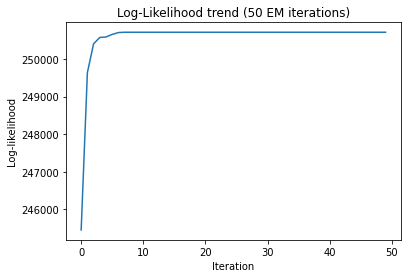

In [69]:
plt.plot(logliks_fit)
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood")
plt.title("Log-Likelihood trend (50 EM iterations)")
plt.show()

# IV. Evaluate authorship via Hypergeometric test


Lastly, we will perform a hypergeometric test that will assess our clusters for enrichment in articles authored by each of the people of interest (Hamilton, Madison, Jay).

The <span style='background :greenyellow'>null hypothesis</span> is that the assignment of articles to clusters is completely random, and there is no association between our clusters and authors of articles. 


Given a cluster and an author, the p-values provided by the hypergeometric test correspond to the  <span style='background :greenyellow'> chance that the author was assigned to the articles in the cluster ***at random***.</span> Lower p-value confers *higher significance*. Therefore, if we observe a low p-value then we can reject the null in favor of the alternative hypothesis, which is: the association between the given author and the given cluster is NOT by chance.

In [70]:
def gen_table( labels, documents ):
    K = len(np.unique(labels))
    authorList = np.asarray([doc['authors'] for doc in documents])
    nameList = np.asarray( ['JAY', 'MADISON', 'HAMILTON'] )
    nameList2 = np.asarray( ['JAY', 'MADISON', 'HAMILTON', ''] )
    nameNum = {'JAY': 5, 'MADISON': 14, 'HAMILTON': 51}
    enrichment = np.zeros((K, 3))
    numberTab = np.zeros((K,4))
    for i in np.arange(K):
        cList = authorList[np.nonzero(labels==i)[0]]
        cnt = 0
        for j in nameList:
            rv = hypergeom(70, nameNum[j], len(cList) )
            cIntersect = len(np.nonzero(cList==j)[0])
            enrichment[i, cnt] = 1-rv.cdf(cIntersect)
            numberTab[i, cnt] = cIntersect
            cnt = cnt + 1
        cnt = 0
        for j in nameList2:
            cIntersect = len(np.nonzero(cList==j)[0])
            numberTab[i, cnt] = cIntersect
            cnt = cnt + 1
    return enrichment, numberTab

def report_table(enrichment, numberTab):
    nameList = np.asarray( ['JAY', 'MADISON', 'HAMILTON'] )
    nameList2 = np.asarray( ['JAY', 'MADISON', 'HAMILTON', 'DISPUTED'] )
    print( '* * * HYPERGEOMETRIC TEST RESULTS * * * \n')
    print( 'p-values: ')
    print('\t\t', end="")
    for z in nameList:
        print('{0:<8}\t'.format(z), end='')
    print()
    for i in range(4):
        print('cluster {}\t'.format(i), end='')
        for j in range(3):
            print('{0:3f}\t'.format(enrichment[i, j]), end='')
        print()

    print( '\n\ncount table: ')
    print('\t\t', end="")
    for z in nameList2:
        print('{0:<8}\t'.format(z), end='')
    print()
    for i in range(4):
        print('cluster {}\t'.format(i), end='')
        for j in range(4):
            print('{0:<8}\t'.format(int(numberTab[i, j])), end='')
        print()
        
enrichment, numberTab = gen_table(labels_fit, documents)
report_table(enrichment,numberTab)

* * * HYPERGEOMETRIC TEST RESULTS * * * 

p-values: 
		JAY     	MADISON 	HAMILTON	
cluster 0	0.000961	0.993311	0.919420	
cluster 1	0.654044	0.077191	0.754442	
cluster 2	0.945633	0.998012	0.004683	
cluster 3	0.534303	0.001177	1.000000	


count table: 
		JAY     	MADISON 	HAMILTON	DISPUTED	
cluster 0	4       	0       	11      	4       	
cluster 1	0       	4       	8       	1       	
cluster 2	0       	1       	26      	3       	
cluster 3	1       	9       	6       	7       	


13) **<span style='background :yellow'>(2pt)</span>**  <font color=blue>According to the results of the hypergeometric test, which **single** author is *most likely* to have penned disputed articles? Provide a *short* (**no more than 50 words**) explanation; reference why the p-value and the respective counts lead you to your conclusion.

In [ ]:
#Madison is most likely to have penned disputed articles. Considering at 5% confidence level, cluster 0 belongs to Jay,
#cluster 2 belongs to  Hamilton, and cluster 3 belongs to Madison. Considering at 10% signiciance level,cluster 1 belongs
#to Madison. Looking at the count table, Jay has 4 disputed articles, Madison has 8 disputed articles, and Hamilton
#has 3 disputed articles. Therefore, Madison has the most disputed articles, meaning he is most likely to have penned 
#diputed articles.